# STEP 0: UPLOAD IMAGE AND DEFINE METRICS

In [ ]:
#INSTALL DEEP INVERSE AND BM3D
%%capture
!pip install git+https://github.com/deepinv/deepinv.git
!pip install bm3d

In [ ]:
#IMPORT LIBRARY
import torch
import deepinv as dinv
import matplotlib.pyplot as plt
from deepinv.optim.prior import Prior
from deepinv.utils import load_url_image, get_image_url

torch.manual_seed(0)

In [ ]:
dinv.__version__

'0.3'

In [ ]:
#DEFINE THE METRICS TO EVALUATE RESULTS
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
PSNR_metric = dinv.loss.metric.PSNR()
SSIM_metric = dinv.loss.metric.SSIM()

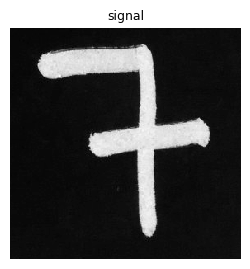

In [ ]:
#UPLOAD THE IMAGE

#save the url from the folder
url = ("https://i.sstatic.net/fyPhv.jpg")
img_size = 280

#load the image using the url
x_mnist = load_url_image(url=url, img_size=img_size, grayscale=True, device=device)

#take negative image
x_mnist = 1 - x_mnist

#plot
dinv.utils.plot([x_mnist], ["signal"], figsize=(3,3))

# STEP 1: DEFINE PHYSICS (SYNTETIC MEASURAMENT Y)

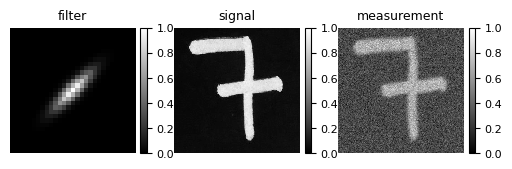

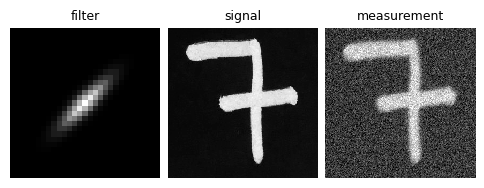

In [ ]:
#GENERATE A SYNTETIC MEASURAMENT

#1. SET NOISE: GAUSSIAN
noise_model=dinv.physics.GaussianNoise(sigma=0.1)

#2. SET BLUR: GAUSSIAN
filter = dinv.physics.blur.gaussian_blur(sigma=(1, 4), angle=45)

#3. SET OPERATOR: BLURFFT
physics = dinv.physics.BlurFFT(filter=filter, img_size=(1, img_size, img_size),\
                            noise_model=noise_model,\
                                device=device)
#4. GENERATE IMAGE
y = physics(x_mnist)

#5. PLOT
# cbar=True: plot the scale bar. automatically set rescale_mode='clip' so compress gray between 0 and 1
dinv.utils.plot([filter, x_mnist, y], ["filter","signal", "measurement"], cbar=True)
dinv.utils.plot([filter, x_mnist, y], ["filter","signal", "measurement"], rescale_mode='clip') #compressed to [0,1]


# STEP 2: DEFINE RECONSTRUCTION MODEL

To define the reconstruction model we need to define
1. DATA FIDELITY: can be L1-norm or L2-norm
2. PRIOR (REGULARIZER): can be zero, L1, L2, Tikonov, Tv, BM3D PnP, MedianFilter Pnp, DnCNN PnP, DRUNet Pnp

# STEP 2.1:   0 PRIOR

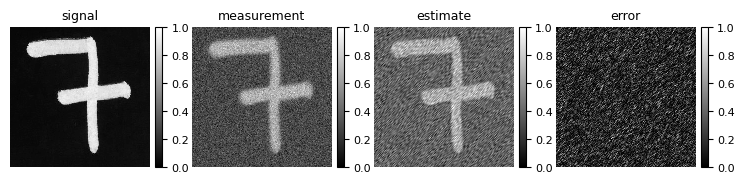

PSNR: 14.995862007141113
SSIM: 0.07967603951692581


In [ ]:
#1. DEFINE DATA FIDELITY: L2 NORM
data_fidelity = dinv.optim.data_fidelity.L2()

#2. DEFINE PRIOR: ZERO
prior = dinv.optim.prior.Zero()

#3. DEFINE RECONSTRUCTION MODEL:
#       iteration: set the proximal gradient descendt
#       max_iter: set max numb of iteration to 100
#       crit_conv: set convergence critiria the residual one
#       thres_conv: set the threshold for convergence critiria
#       params_alg: stepsize (convergence), lambda

#choosing as prior g(x)=0 --> the proximal operator is Identity
#                          --> we are running the grad descend of square fidelity without regularization

rec_model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                 max_iter=100, crit_conv='residual', thres_conv=1e-4, early_stop=True, \
                                 params_algo={"stepsize": 1.0, "lambda": 3e-2})

#4. RUN RECONSTRUCTION MODEL ON THE AQUIRE MESURAMENT Y WITH PHYSICS ABOVE
x_hat = rec_model(y, physics)

#5. DEFINE ERROR BETWEEN REAL AND RECONSTRUCT IMAGE
error = torch.abs(x_hat-x_mnist)

#6. PLOT:
#      x_mnist: real image
#      y: measurament
#      x_hat: reconstructed image
#      error
dinv.utils.plot([x_mnist, y, x_hat, error], ["signal", "measurement", "estimate", "error"], cbar=True, figsize=(9,3))

#7.COMPUTE METRIC
print(f'PSNR: {PSNR_metric(x_hat,x_mnist).item()}')
print(f'SSIM: {SSIM_metric(x_hat,x_mnist).item()}')

# STEP 2.2: L1 PRIOR

In [ ]:
#1. DEFINE DATA FIDELITY: L2 NORM
data_fidelity = dinv.optim.data_fidelity.L2()

#2. DEFINE PRIOR: L1
prior = dinv.optim.prior.L1Prior()

#3. DEFINE RECONSTRUCTION MODEL:
rec_model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                 max_iter=100, crit_conv='residual', thres_conv=1e-4, early_stop=True, \
                                 params_algo={"stepsize": 1.0, "lambda": 0.1})

#4. RUN RECONSTRUCTION MODEL
x_hat = rec_model(y, physics)

#5. DEFINE ERROR
error = torch.abs(x_hat-x_mnist)

#6. PLOT:
dinv.utils.plot([x_mnist, y, x_hat, error], ["signal", "measurement", "estimate", "error"], cbar=True, figsize=(9,3))

#7.COMPUTE METRIC
print(f'PSNR: {PSNR_metric(x_hat,x_mnist).item()}')
print(f'SSIM: {SSIM_metric(x_hat,x_mnist).item()}')

NameError: name 'y' is not defined

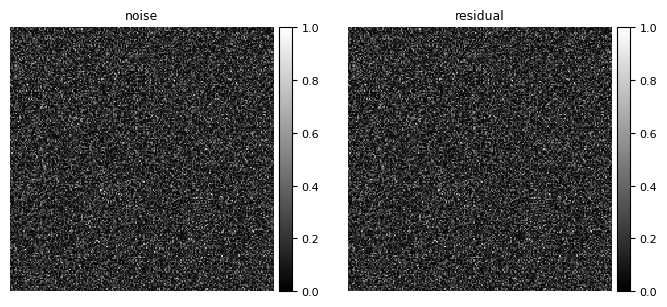

Noise norm:  19.96062660217285
Residual norm:  19.884111404418945


In [ ]:
noise = physics.A(x_mnist) - y
residual= physics.A(x_hat) - y

dinv.utils.plot([torch.abs(noise), torch.abs(residual)], ["noise", "residual"], cbar=True, figsize=(8,4))

print('Noise norm: ', noise.norm().item())
print('Residual norm: ', residual.norm().item())

PLOT THE GRAPH OF METRICS

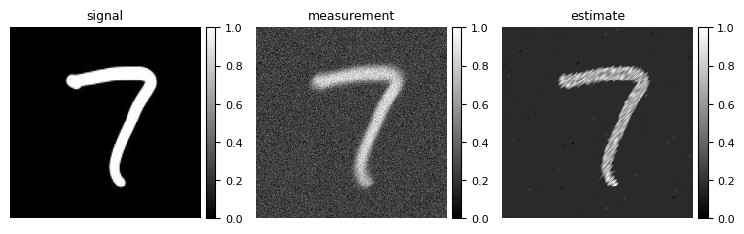

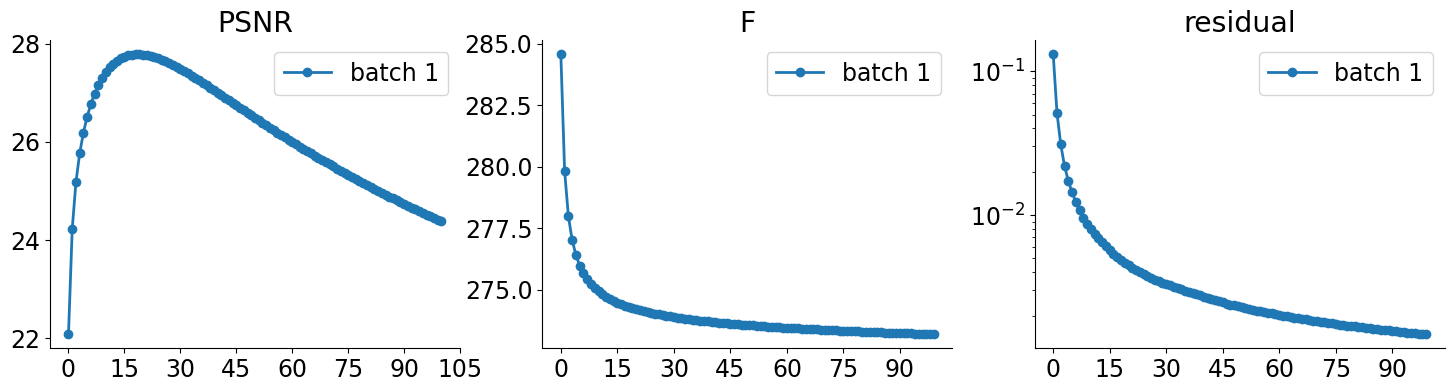

PSNR: 24.378873825073242
SSIM: 0.8923380374908447


In [ ]:
#3. DEFINE RECONSTRUCTION MODEL:
rec_model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                 max_iter=100, crit_conv='residual', thres_conv=1e-3, early_stop=True, \
                                 params_algo={"stepsize": 1.0, "lambda": 3e-2})

#4.1 --> RUN RECONSTRUCTION MODEL AND COMPUTE METRICS
#    -compute_metrics=True: allow to plot the metrics
#    -x_gt=x_mnist: we have to paass the true value of image
x_hat, metrics = rec_model(y, physics, x_gt=x_mnist, compute_metrics=True)

#6. PLOT TRUE VALUE, MESURAMENT AND RECONSTRUCTED IMAGE
dinv.utils.plot([x_mnist, y, x_hat], ["signal", "measurement", "estimate"], cbar=True, figsize=(9,3))

#7.PLOT THE GRAPH OF METRICS
#   PSNR: Similitude between the reconstructed and real for each image created during the iterat
#   F: Behaviour in terms of Functional values
#   residual: Behaviour in terms of Relative change
dinv.utils.plot_curves(metrics)

#8.METRICS VALUE
print(f'PSNR: {PSNR_metric(x_hat,x_mnist).item()}')
print(f'SSIM: {SSIM_metric(x_hat,x_mnist).item()}')

# STEP 2.3.1: L2 PRIOR (AS CLASS)


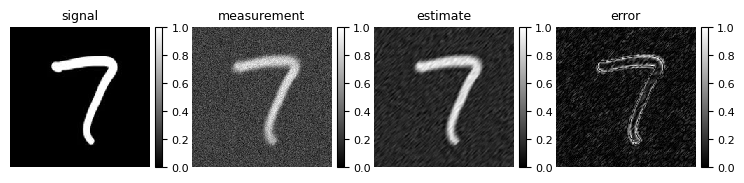

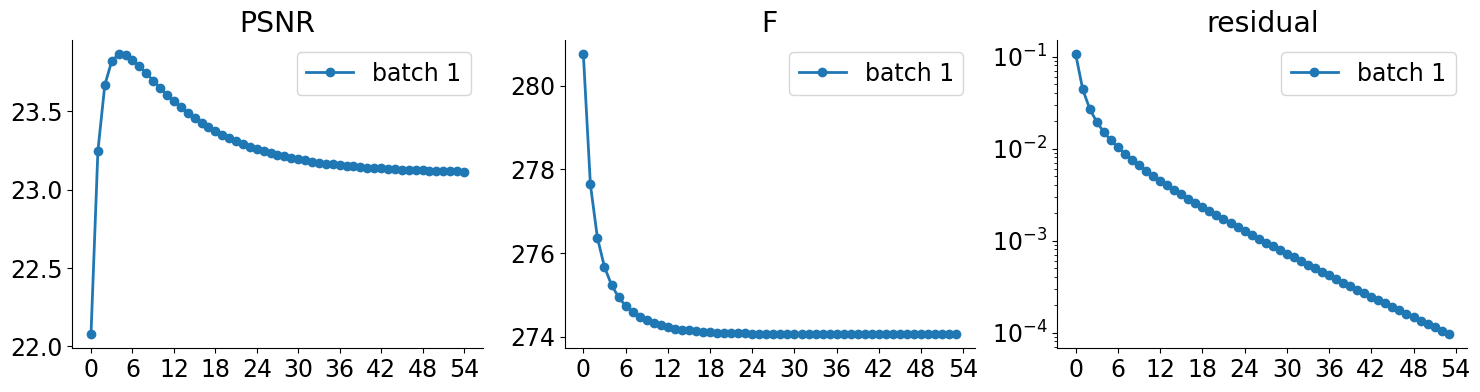

PSNR: 23.11573028564453
SSIM: 0.2100888341665268


In [ ]:
# CREATE A PRIROR AS CLASS FROM THE BASE PRIOR CLASS
class L2Prior(Prior):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # WE STATE WE COMPUTE AN EXPLICIT PRIOR
        self.explicit_prior = True

    # DEFINE THE FUNCTIONAL EVALUATION
    def fn(self, x, args, **kwargs):
        # COMPUTE L2-NORM SQUARED OF IMAGE
        return 0.5 * torch.norm(x.view(x.shape[0], -1), p=2, dim=-1) ** 2

# SET THE PRIOR
prior = L2Prior()

#3. DEFINE RECONSTRUCTION MODEL:
rec_model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                 max_iter=100, crit_conv='residual', thres_conv=1e-4, early_stop=True, \
                                 params_algo={"stepsize": 1.0, "lambda": 8e-2})

#4. RUN RECONSTRUCTION MODEL AND COMPUTE METRICS
x_hat, metrics = rec_model(y, physics, x_gt=x_mnist, compute_metrics=True)

#5.COMPUTE ERROR
error = torch.abs(x_hat-x_mnist)

#6.1 PLOT BOTH IMAGES AND METRICS
dinv.utils.plot([x_mnist, y, x_hat, error], ["signal", "measurement", "estimate", "error"], cbar=True, figsize=(9,3))
dinv.utils.plot_curves(metrics)

#7.PRINT METRICS
print(f'PSNR: {PSNR_metric(x_hat,x_mnist).item()}')
print(f'SSIM: {SSIM_metric(x_hat,x_mnist).item()}')

# STEP 2.3.2: L2 PRIOR (AS FNCT)

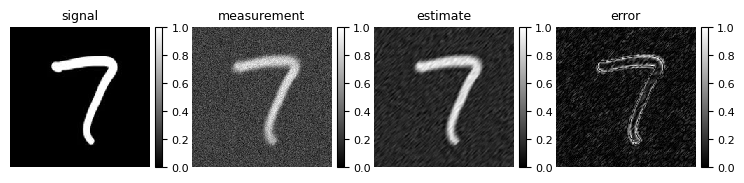

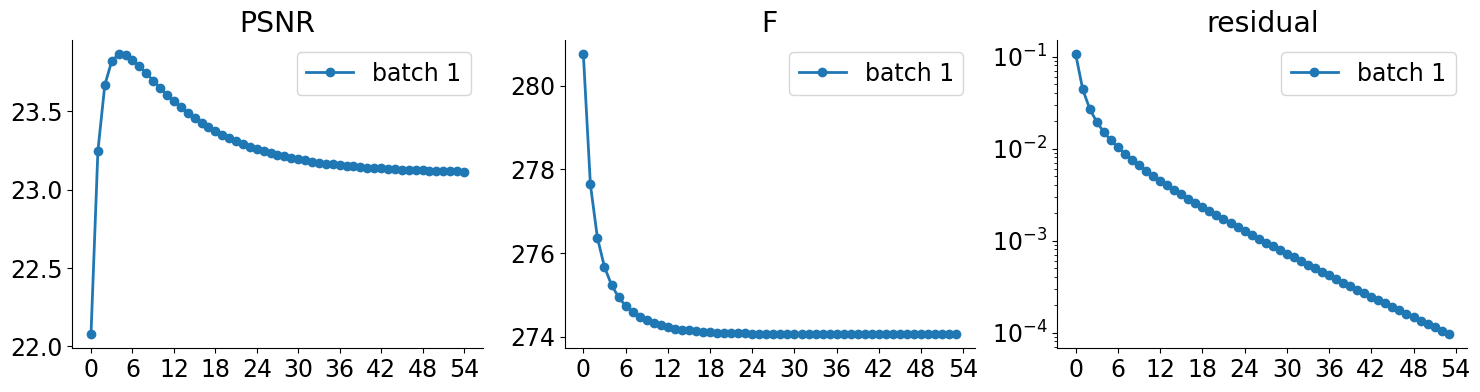

PSNR: 23.11573028564453
SSIM: 0.2100888341665268


In [ ]:
# DEFINE THE FUNCTION COMPUTE THE L2-SQUARED NORM
#   x: image
#   *args, **kwargs: fixed to avoid error
def g(x, *args, **kwargs):
    return 0.5 * torch.norm(x.view(x.shape[0], -1), p=2, dim=-1) ** 2

# SET THE PRIOR FROM THE FUNCTION ABOVE
prior = Prior(g=g)

#3. DEFINE RECONSTRUCTION MODEL:
rec_model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                 max_iter=100, crit_conv='residual', thres_conv=1e-4, early_stop=True, \
                                 params_algo={"stepsize": 1.0, "lambda": 8e-2})

#4. RUN RECONSTRUCTION MODEL AND COMPUTE METRICS
x_hat, metrics = rec_model(y, physics, x_gt=x_mnist, compute_metrics=True)

#5.COMPUTE ERROR
error = torch.abs(x_hat-x_mnist)

#6.1 PLOT BOTH IMAGES AND METRICS
dinv.utils.plot([x_mnist, y, x_hat, error], ["signal", "measurement", "estimate", "error"], cbar=True, figsize=(9,3))
dinv.utils.plot_curves(metrics)

print(f'PSNR: {PSNR_metric(x_hat,x_mnist).item()}')
print(f'SSIM: {SSIM_metric(x_hat,x_mnist).item()}')

# STEP 2.4: GENERALIZED TIKONOV PRIOR

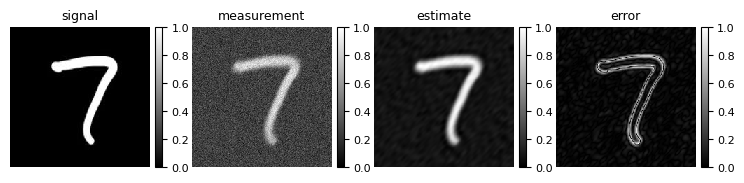

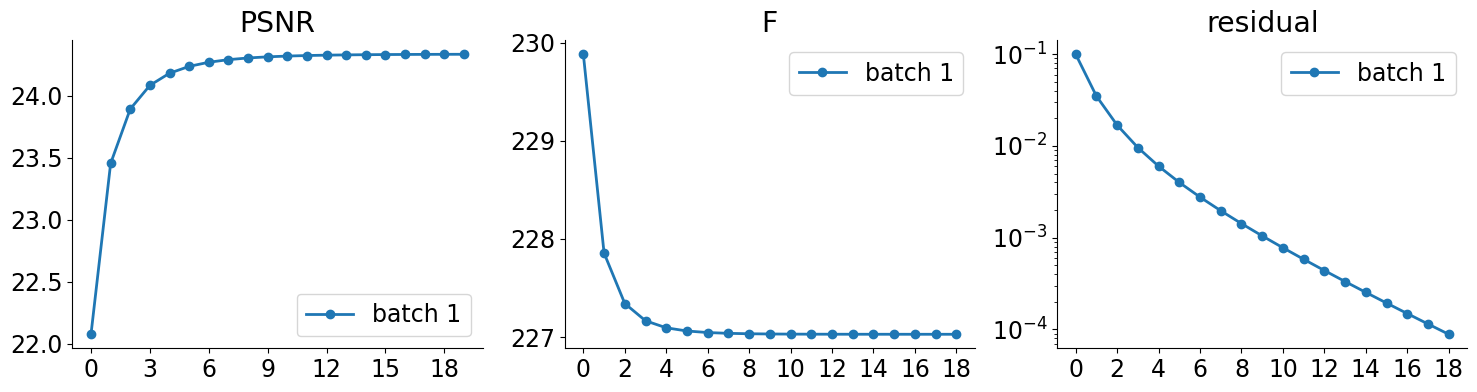

PSNR: 24.33606719970703
SSIM: 0.4509738087654114


In [ ]:
# DEFINE THE TIKONOV PRIOR
class TikhonovG(Prior):

    def __init__(self,  *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.explicit_prior = True

        # DEFINE 2 FILTERS (KERNELS) OF SIZE (3,3) TO STORE VALUES OF FINITE DIFFERENCE FOR GRADIENT
        filt1 = torch.zeros(1,1,3,3)
        filt2 = torch.zeros(1,1,3,3)

        filt1[...,1,1] = -1
        filt2[...,1,1] = -1

        filt1[...,1,0] = 1
        filt2[...,0,1] = 1

        # DEFINE 2 PHYSUCS TO WHICH APLLY THE FILTERS
        physics1 = dinv.physics.BlurFFT(img_size=(1, img_size, img_size), filter=filt1, device=device)  #filter1
        physics2 = dinv.physics.BlurFFT(img_size=(1, img_size, img_size), filter=filt2, device=device)  #filter2

        # DEFINE A 3 PHYSICS from 1,2 / A3(x)=A1(x)°A2(x)
        self.physics3 = dinv.physics.stack(physics1, physics2)

    # COMPUTE FUNCTIONAL EVALUATION OF GRADIENT
    def fn(self, x, *args, **kwargs):
        res = self.physics3(x)
        out = 0
        # COMPUTE AND STORE L2-NORM OF GRADIENT
        for i in range(2):
            out +=  0.5*torch.norm(res[i], p=2)**2
        return out

    # COMPUTE THE PROXIMAL MAP OF PHYSICS 3:
    #    when compute proiximal gradient decsend we need the prox of my operator, so the prox of prior
    def prox(self, x, *args, gamma=1.0, **kwargs):
        y = torch.stack((torch.zeros_like(x), torch.zeros_like(x))).squeeze(0)
        return self.physics3.prox_l2(x, y, gamma)

# SET THE PRIOR
prior = TikhonovG()

#3. DEFINE RECONSTRUCTION MODEL:
rec_model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                 max_iter=100, crit_conv='residual', thres_conv=1e-4, early_stop=True, \
                                 params_algo={"stepsize": 1.0, "lambda": 1.})

#4. RUN RECONSTRUCTION MODEL AND COMPUTE METRICS
x_hat, metrics = rec_model(y, physics, x_gt=x_mnist, compute_metrics=True)

#5. COMPUTE ERROR
error = torch.abs(x_hat-x_mnist)

#6.1. PLOT BOTH IMAGES AND METRICS
dinv.utils.plot([x_mnist, y, x_hat, error], ["signal", "measurement", "estimate", "error"], cbar=True, figsize=(9,3))
dinv.utils.plot_curves(metrics)

#7. METRICS
print(f'PSNR: {PSNR_metric(x_hat,x_mnist).item()}')
print(f'SSIM: {SSIM_metric(x_hat,x_mnist).item()}')


# STEP 2.5: TOTAL VARIATION (TV) PRIOR

TOTAL VARIATIONAL L2 is the best to solve this kind of problem cause our image is perceptive piecewise constant

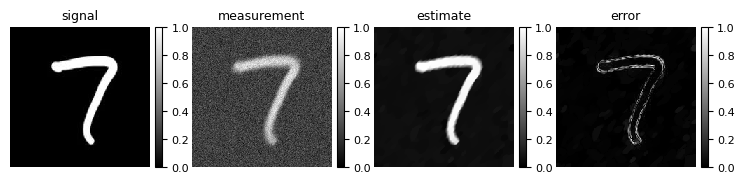

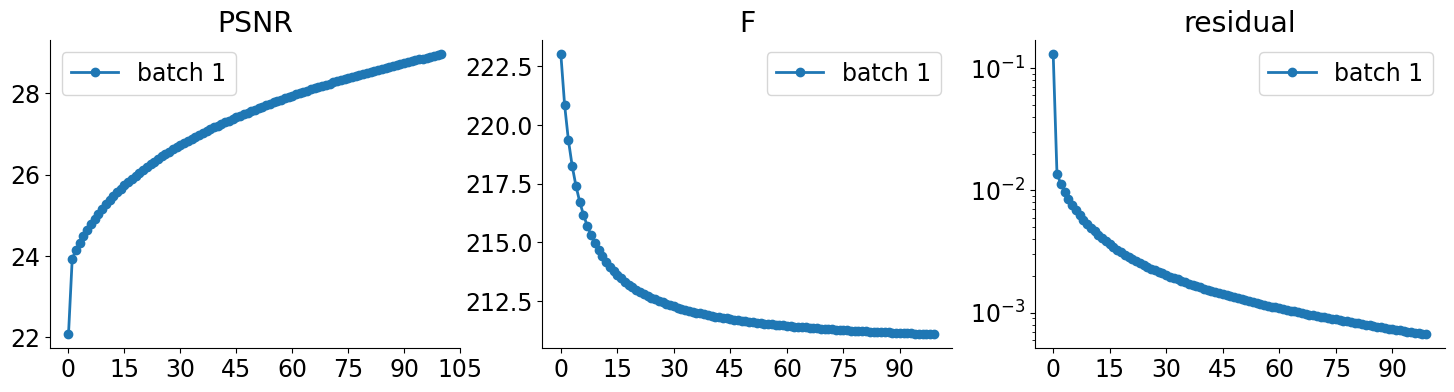

PSNR: 28.959774017333984
SSIM: 0.7503066658973694


In [ ]:
#1. DATA FIDELITY L2
data_fidelity = dinv.optim.data_fidelity.L2()

#2. PRIOR TV
#        -n_it_max=10: specify max numb of iteration to compute the prox
prior = dinv.optim.prior.TVPrior(n_it_max=10)

#3. DEFINE RECONSTRUCTION MODEL
rec_model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                 max_iter=100, crit_conv='residual', thres_conv=1e-4, early_stop=True, \
                                 params_algo={"stepsize": 1.0, "lambda": 3e-2})

#4. COMPUTE IMAGE AND METRIC
x_hat, metrics = rec_model(y, physics, x_gt=x_mnist, compute_metrics=True)

#5. COMPUTE ERROR
error = torch.abs(x_hat-x_mnist)

#6.1. PLOT IMAGES AND METRICS
dinv.utils.plot([x_mnist, y, x_hat, error], ["signal", "measurement", "estimate", "error"], cbar=True, figsize=(9,3))
dinv.utils.plot_curves(metrics)

print(f'PSNR: {PSNR_metric(x_hat,x_mnist).item()}')
print(f'SSIM: {SSIM_metric(x_hat,x_mnist).item()}')

#STEP 2.6.1: PNP PRIOR + MEDIAN FILTER DENOISER

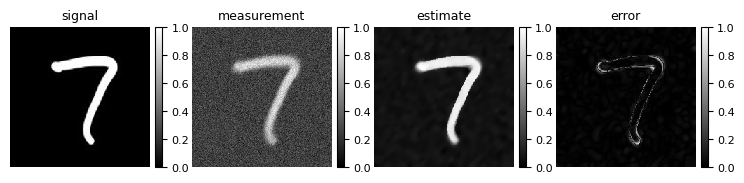

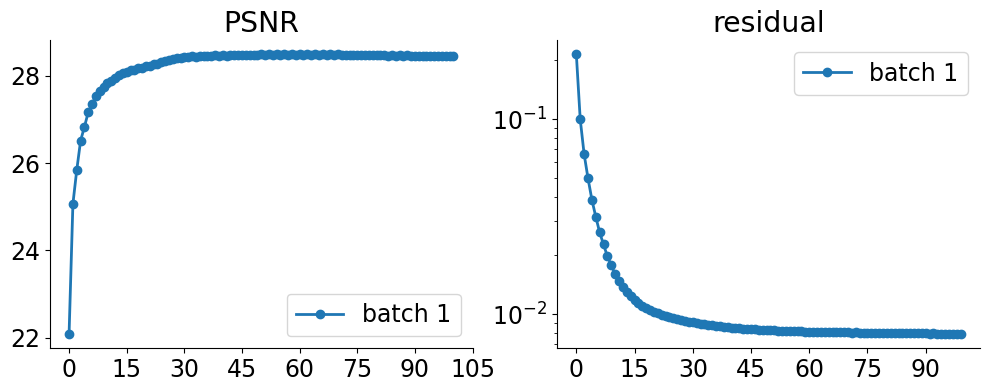

PSNR: 28.453868865966797
SSIM: 0.5933634042739868


In [ ]:
#1. DEFINING DENOISE FOR PNP
denoiser = dinv.models.MedianFilter()

#2. DEFINE PRIOR AS PNP + DENOISER
prior = dinv.optim.prior.PnP(denoiser=denoiser)

#3. RECONSTRUCTION MODEL
#       -"stepsize": for convergence
#       -"g_param": how much noise we wnat to remove
rec_model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                 max_iter=100, crit_conv='residual', thres_conv=1e-4, early_stop=False, \
                                 params_algo={"stepsize": 2, "g_param": 1e-1 }, \
                                )
#4.
x_hat, metrics = rec_model(y, physics, x_gt=x_mnist, compute_metrics=True)

#5.
error = torch.abs(x_hat-x_mnist)

#6.
dinv.utils.plot([x_mnist, y, x_hat, error], ["signal", "measurement", "estimate", "error"], cbar=True, figsize=(9,3))
dinv.utils.plot_curves(metrics)

print(f'PSNR: {PSNR_metric(x_hat,x_mnist).item()}')
print(f'SSIM: {SSIM_metric(x_hat,x_mnist).item()}')

#STEP 2.6.2: PNP PRIOR + BM3D DENOISER

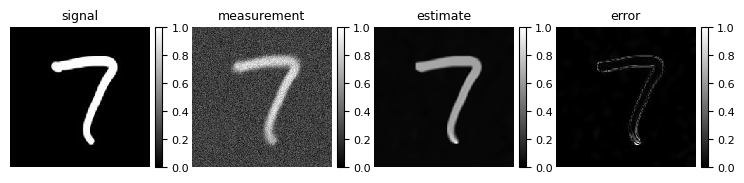

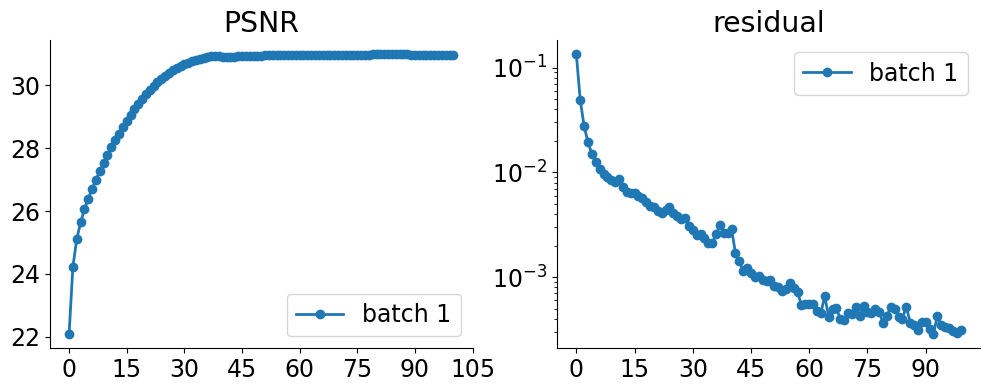

PSNR: 30.966533660888672
SSIM: 0.8794249892234802


In [ ]:
#1. DEFINING DENOISE FOR PNP
denoiser = dinv.models.BM3D()

#2. DEFINE PRIOR AS PNP + DENOISER
prior = dinv.optim.prior.PnP(denoiser=denoiser)

#3. RECONSTRUCTION MODEL
rec_model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                 max_iter=100, crit_conv='residual', thres_conv=1e-4, early_stop=False, \
                                 params_algo={"stepsize": 1, "g_param": 1e-1 }
                                )
#4.
x_hat, metrics = rec_model(y, physics, x_gt=x_mnist, compute_metrics=True)

#5.
error = torch.abs(x_hat-x_mnist)

#6.
dinv.utils.plot([x_mnist, y, x_hat, error], ["signal", "measurement", "estimate", "error"], cbar=True, figsize=(9,3))
dinv.utils.plot_curves(metrics)

print(f'PSNR: {PSNR_metric(x_hat,x_mnist).item()}')
print(f'SSIM: {SSIM_metric(x_hat,x_mnist).item()}')

#STEP 2.6.3: PNP PRIOR + DNCNN DENOISER

DEFINING THE DNCNN DENOISER MEANS DEFINING A NEURAL NETWORK

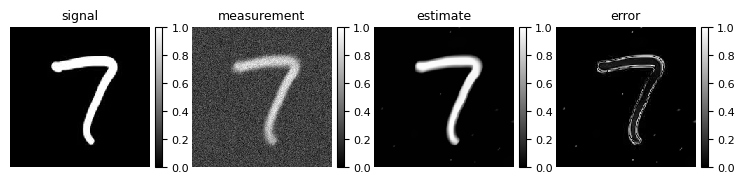

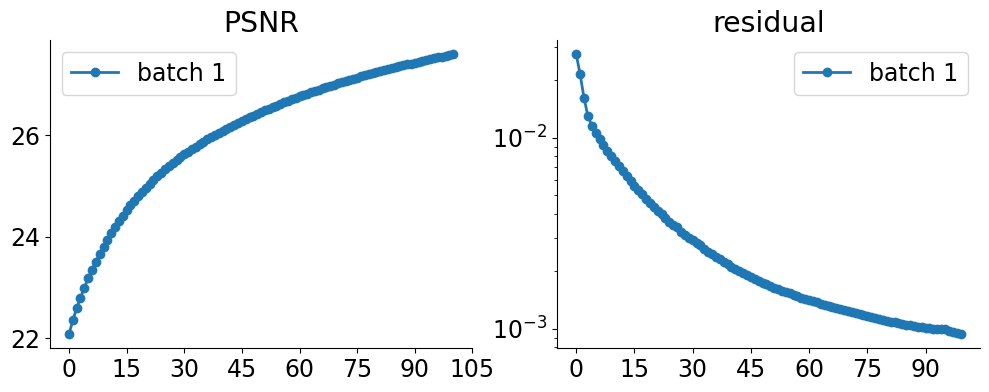

PSNR: 27.596595764160156
SSIM: 0.9463323950767517


In [ ]:
#1. DEFINING DENOISE FOR PNP
#     -in_channels=1  : we are working with image having 1 channel (black and white images)
#     -out_channels=1 : we want to end up with image having 1 channel (black and white images)
#     -pretrained='download. : we want to downloads the pretrained weights
denoiser = dinv.models.DnCNN(
    in_channels=1,          # num of channel of initial image
    out_channels=1,         # num of channel of final imagge
    pretrained='download',  # downloads the pretrained weights
    device=device,
)

#2. DEFINE PRIOR WITH PNP + DENOISER
prior = dinv.optim.prior.PnP(denoiser=denoiser)

#3. DEFINE RECONSTRUCTION MODEL
rec_model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                 max_iter=100, crit_conv='residual', thres_conv=1e-4, early_stop=False, \
                                 params_algo={"stepsize": 0.1, "g_param": 1e-1 }, # 0.1
                                )
#4.
x_hat, metrics = rec_model(y, physics, x_gt=x_mnist, compute_metrics=True)

#5.
error = torch.abs(x_hat-x_mnist)

#6.
dinv.utils.plot([x_mnist, y, x_hat, error], ["signal", "measurement", "estimate", "error"], cbar=True, figsize=(9,3))
dinv.utils.plot_curves(metrics)

print(f'PSNR: {PSNR_metric(x_hat,x_mnist).item()}')
print(f'SSIM: {SSIM_metric(x_hat,x_mnist).item()}')

# STEP 2.6.4: PNP PRIOR + DRUNET DENOISER

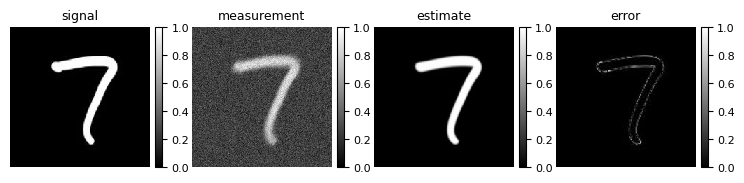

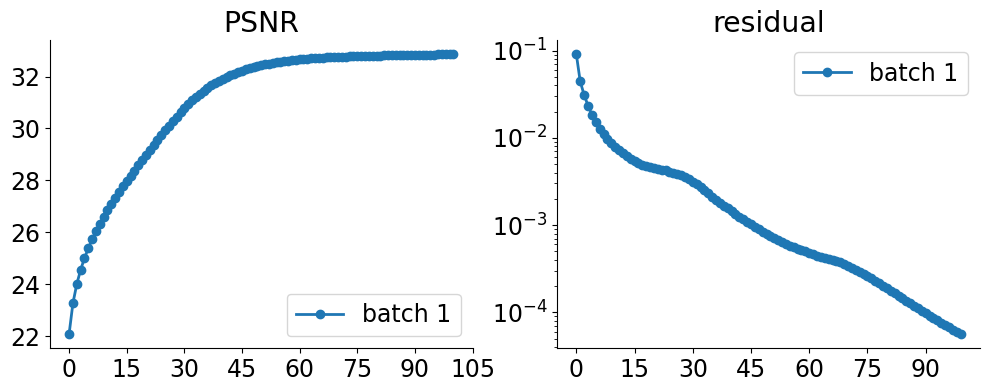

PSNR: 32.85563278198242
SSIM: 0.9848530888557434


In [ ]:
#1. DEFINING DENOISE FOR PNP
denoiser = dinv.models.DRUNet(
    in_channels=1,          # num of channel of initial image
    out_channels=1,         # num of channel of final image
    pretrained='download',  # downloads the pretrained weights
    device=device,
)

#2. DEFINE PRIOR WITH PNP + DENOISER
prior = dinv.optim.prior.PnP(denoiser=denoiser)

#3. DEFINE RECONSTRUCTION MODEL
rec_model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                 max_iter=100, crit_conv='residual', thres_conv=1e-4, early_stop=False, \
                                 params_algo={"stepsize": 0.5, "g_param": 1e-1 }, # 0.1
                                )
#4.
x_hat, metrics = rec_model(y, physics, x_gt=x_mnist, compute_metrics=True)

#5.
error = torch.abs(x_hat-x_mnist)

#6.
dinv.utils.plot([x_mnist, y, x_hat, error], ["signal", "measurement", "estimate", "error"], cbar=True, figsize=(9,3))
dinv.utils.plot_curves(metrics)

print(f'PSNR: {PSNR_metric(x_hat,x_mnist).item()}')
print(f'SSIM: {SSIM_metric(x_hat,x_mnist).item()}')

# FUNCTION TO FIND PARAMETER

In [1]:
import numpy as np

err_list = []
PSNR_list = []
SSIM_list = []
#CHOOSE THE RANGE IN WHICH SEEK FOR PARAMETER
par_list = np.linspace(1e-3, 5e-1)

for par in par_list:
    model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity, \
                                    max_iter=100, crit_conv='residual', thres_conv=1e-4, early_stop=True, \
                                    param_algo = {"stepsize": 1., "lambda": par, "g_param": 1.}
                                    )
    x_hat = model(y, physics)
    error = torch.abs(x_hat-x_mnist)
    err_list.append(error.norm().item())

    PSNR= PSNR_metric(x_hat,x_mnist).item()
    SSIM= SSIM_metric(x_hat,x_mnist).item()

    PSNR_list.append(PSNR)
    SSIM_list.append(SSIM)

fig, axs = plt.subplots(1, 3)
axs[0].plot(err_list)
axs[1].plot(PSNR_list)
axs[2].plot(SSIM_list)
plt.show()

NameError: name 'dinv' is not defined